# FIT5226 Assignment 3 : Project Stage 3

## Group members :
###### Darren Jer Shien Yee (31237223)
###### Jian Xin Kin (31165087)
###### Yi Jie Ng (31158145)

***

## Provided PyTorch code from Stage3Skeleton

In [1]:
import torch
import copy

In [2]:
class DQN:
    def __init__(self, state_size = 78, action_size = 4):
        l1 = state_size
        l2 = 32
        l3 = 32
        l4 = action_size
        self.model = torch.nn.Sequential(
        torch.nn.Linear(l1, l2),
        torch.nn.ReLU(),
        torch.nn.Linear(l2, l3),
        torch.nn.ReLU(),
        torch.nn.Linear(l3,l4)
        )
        
        for layer in self.model:
            if isinstance(layer, torch.nn.Linear):
                # Apply Xavier (Glorot) initialization to linear layers
                torch.nn.init.xavier_uniform_(layer.weight)
                torch.nn.init.zeros_(layer.bias)  # You can initialize biases to zeros

        self.model2 = copy.deepcopy(self.model)
        self.model2.load_state_dict(self.model.state_dict())
        self.loss_fn = torch.nn.MSELoss()
        self.learning_rate = 0.001
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    # The function "update_target" copies the state of the prediction network to the target network. 
    # You need to use this in regular intervals.
    def update_target(self):
        self.model2.load_state_dict(self.model.state_dict())

    # The function "get_qvals" returns a numpy list of qvals for the state given by the argument 
    # based on the prediction network.
    def get_qvals(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0)
        q_values = self.model(state)
        return q_values

    # The function "get_maxQ" returns the maximum q-value for the state given by the argument 
    # based on the target network.
    def get_maxQ(self,state):
        q_values = self.model2(state)
        return torch.max(q_values).item()

    # The function "train_one_step_new" performs a single training step.
    # It returns the current loss (only needed for debugging purposes).
    # Its parameters are three parallel lists: a minibatch of states, a minibatch of actions,
    # a minibatch of the corresponding TD targets and the discount factor.
    def train_one_step(self, states, actions, targets):
        targets_reply = []
        state1_batch = torch.cat([torch.from_numpy(s).float() for s in states])
        action_batch = torch.Tensor(actions)
        Q1 = self.model(state1_batch)
        X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
        Y = torch.tensor(targets).float()
        loss = self.loss_fn(X, Y)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

## General Imports

In [3]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.widgets import Button, Slider
import matplotlib.cm as cm

import random as RD
import copy as copy
import scipy as SP
import math
import statistics

import time, threading

In [4]:
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objects as go

from IPython.display import clear_output

## Simulation code

In [5]:
def simulation(grid_args):
    global config, fig, ax, bnext, bstart, bstop, binit, empty, unhappiness, avg_similarity
    # apparently the buttons need to be declared as global to avoid
    # that they are garbage-collected. If this happens they will still be visible but become inactive

    def stopAnim(d):
        global stop
        stop=True

    def startAnim(d):
        global stop
        stop=False
        foo()

    def advance(d):
        global mat, config, plt, time
        time += 1

        # ADD STEP HERE

        grid_args.update_grid_world()

        # UPDATE GLOBAL CONFIG TABLE FOR VISUALISATION
        config = grid_args.config

        # END STEP HERE

        mat.set_data(config)
        plt.title('t = ' + str(time))
        plt.show()

    def initAnim(d):
        global mat, config, plt, time
        
        # Reinitialise grid world
        grid_args.__init__(grid_args.size)

        # Init config
        config = grid_args.config

        time = 0
        mat = ax.matshow(config, cmap=cm.seismic)
        mat.set_data(config)
        plt.title('t = ' + str(time))
        plt.show()

    def updateSpeed(val):
        global speed
        speed = 0.001/sspeed.val

    def foo():
        global speed, timer, stop
        advance(None)
        if not(stop):
            timer=threading.Timer(speed, foo)
            timer.start()


    RD.seed()
    fig, ax = plt.subplots()
    ax.axis('off')
    plt.title("FIT5226 Assignment 3: Project Phase 3")

    axspeed = plt.axes([0.175, 0.05, 0.65, 0.03])
    sspeed = Slider(axspeed, 'Speed', 0.1, 10.0, valinit=1.0)
    sspeed.on_changed(updateSpeed)

    axnext = plt.axes([0.85, 0.15, 0.1, 0.075])
    axstart = plt.axes([0.85, 0.25, 0.1, 0.075])
    axstop = plt.axes([0.85, 0.35, 0.1, 0.075])
    axinit = plt.axes([0.85, 0.45, 0.1, 0.075])
    bnext = Button(axnext, 'Next')
    bnext.on_clicked(advance)
    bstart = Button(axstart, 'Start')
    bstart.on_clicked(startAnim)
    bstop = Button(axstop, 'Stop')
    bstop.on_clicked(stopAnim)
    binit = Button(axinit, 'Init')
    binit.on_clicked(initAnim)

    initAnim(None)
    updateSpeed(None)

## Auxiliary Functions for Plotting Results

In [6]:
plotly.offline.init_notebook_mode(connected=True)

In [7]:
# Function to plot the graph of the number for each agent to complete their own goal per episode
def plot_q_learning(grid_world):

    traces = []
    agents = grid_world.agents
    for i in range(len(agents)):
        trace = go.Scatter(
            x=list(range(len(agents[i].graph_steps_taken))),
            y=agents[i].graph_steps_taken,
            mode = 'lines+markers',
            name='Agent {}'.format(agents[i].agent_no)
        )
        traces.append(trace)
    
    return iplot(traces)

In [8]:
# Heatmap function to show the total handover times occured from each coordinate from grid world
def plot_heatmap(grid_world):
    %matplotlib inline
    plt.imshow(grid_world.grid_counts, cmap='YlGnBu', interpolation='nearest')

    for i in range(grid_world.grid_counts.shape[0]):
        for j in range(grid_world.grid_counts.shape[1]):
            plt.text(j, i, str(grid_world.grid_counts[i, j]), ha='center', va='center', color='black', fontsize=12)

    # Color bar 
    plt.colorbar()
    plt.show()

***

## Grid Class

In [9]:
class GridWorld:

    #Grid Representation (0 = Non-significant cells, 1 = Type1 Agent, 2 = Type2 Agent, 3 = Parcel, 4 = Target Location)
    def __init__ (self,size):
        self.size = size
        self.time = 0
        self.replay_init_count = 10000
        self.is_world_goal_completed = False
        self.recent_episode_steps = []
        self.train_flag = True
        
        # Heatmap visualisation
        self.grid_counts = np.zeros((size, size), dtype=int)
        
        # Initialise location of parcel(a_coord), and goal(b_coord)
        self.a_coord = (0, 0)
        self.b_coord = (4, 4)
        
        # Create NN
        self.type1_network = DQN()
        self.type2_network = DQN()
        
        # Create agents
        self.init_agents()
        self.init_replay_table()

        # Create grid
        self.draw_grid_config()

    # Create Agent objects and store them in agents array
    def init_agents(self):
        self.agents = []
        agent1 = Type_1_Agent(1, (np.random.randint(self.size), np.random.randint(self.size)), self)
        agent2 = Type_1_Agent(2, (np.random.randint(self.size), np.random.randint(self.size)), self)
        agent3 = Type_2_Agent(3, (np.random.randint(self.size), np.random.randint(self.size)), self)
        agent4 = Type_2_Agent(4, (np.random.randint(self.size), np.random.randint(self.size)), self)
        self.agents = [agent1, agent2, agent3, agent4]

        for agent in self.agents:
            agent.agent_list = self.agents
            agent.update_state()
                    
    # Function to initialise experience replay table by moving the agent around and interact with the environment.
    def init_replay_table(self):
        
        # Loop N times to initialise N rows of replay experience
        for i in range(self.replay_init_count):
            
            # Ensure epsilon decay does not occur
            for agent in self.agents:
                agent.epsilon = 1.0
            
            # Execute one time-step on the grid world
            self.step()

        # Reinitialise the grid_world
        self.time = 0
        self.is_world_goal_completed = False
        for agent in self.agents:
            agent.complete_episode()
            agent.is_goal_completed = False
            agent.is_active = True
            agent.graph_steps_taken = []
            agent.epsilon = 1
            agent.steps_taken = 0
            agent.episode_count = 0
    
    # Place elements into config matrix for simulation display purposes
    def draw_grid_config(self):
        self.config = np.zeros ((self.size,self.size))
        for agent in self.agents:
            if agent.is_active:
                self.config [agent.x][agent.y] = agent.agent_type + 1
        self.config [self.a_coord] = 4
        self.config [self.b_coord] = 5
    
    # Execute one time-step on the grid world: all all agents to move
    def step(self):
        self.time += 1
        
        # Move agents
        for agent in self.agents:
            if agent.is_active:
                agent.prev_state = agent.state
                agent.step()
            
        # Calculate current reward of each agents and append to their reward table
        for agent in self.agents:
            if agent.is_active:
                agent.update_state()
                agent.current_reward = agent.get_reward()
                agent.append_replay_table()
        
        # Check if an agent completes its goal
        for agent in self.agents:
            if agent.is_active:
                agent.check_complete_episode()
        
        # Deactive agents who has completed their goal until the next episode
        for agent in self.agents:
            if agent.is_goal_completed and agent.is_active:
                agent.is_active = False
        
        # Check if the global goal is completed (Both parcel is delivered)
        self.is_world_goal_completed = self.agents[2].is_goal_completed and self.agents[3].is_goal_completed
        
        # Reset and proceed to next episode if the global goal is completed
        if self.is_world_goal_completed:
            for agent in self.agents:
                agent.is_active = True
                agent.is_goal_completed = False
            self.is_world_goal_completed = False

    # Function to abstract a batch of data from experience replay tables 
    def get_mini_batch(self, replay, network_type):
        
        network = self.type1_network if network_type == 1 else self.type2_network
        
        batch_size = 128
        # Get random samples
        mini_batch = RD.sample(replay, batch_size-32) 
        # Get recent samples
        for i in range(32):
            mini_batch.append(replay[-i])
        
        col_indices = [0,1,2,3]
        result = [list(column) for column in zip(*mini_batch)][col_indices[0]:col_indices[-1]+1]
        
        # Convert states into one-hot representation
        result[0] = self.state_to_one_hot(result[0])
        result[3] = self.state_to_one_hot(result[3])
        
        targets = []
        for i in range(len(mini_batch)):
            targets.append(result[2][i] + (0.9 * network.get_maxQ(torch.from_numpy(result[3][i]).float())))
            
        state = np.array([result[0]])
        action = np.array(result[1])
        targets = np.array(targets)

        return state, action, targets
        
    # Train the network
    def train_network(self):
        for agent in self.agents:
            if agent.is_active:
                if agent.agent_type == 1:
                    state, action, targets = self.get_mini_batch(agent.replay, agent.agent_type)
                    self.type1_network.train_one_step(state, action, targets)
                else:
                    state, action, targets = self.get_mini_batch(agent.replay, agent.agent_type)
                    self.type2_network.train_one_step(state, action, targets)
    
    # Aux function to convert list of XY states into one-hot representation states 
    def state_to_one_hot(self, states):
        output = []
        for state in states:
                        
            newState = self.coordinate_to_one_hot(state[0],state[1])
            newState = np.concatenate((newState,[state[2]]))
            
            newState = np.concatenate((newState,self.coordinate_to_one_hot(state[3],state[4])))
            newState = np.concatenate((newState,[state[5]]))     
            
            newState = np.concatenate((newState,self.coordinate_to_one_hot(state[6],state[7])))
            newState = np.concatenate((newState,[state[8]]))   

            output.append(newState)

        return np.array(output)
    
    # Aux function to convert XY coordinates in state array into 25-sized one hot representation
    def coordinate_to_one_hot(self, x, y, grid_size=5):
        # Calculate the index in the one-hot vector
        index = x + y * grid_size

        # Create a one-hot vector of length grid_size * grid_size
        one_hot = np.zeros(grid_size * grid_size)

        # Set the corresponding index to 1
        one_hot[index] = 1
    
        return one_hot
    
    # A buffer used to contain the recent number of steps used to deliver the parcel
    def append_recent_episode_steps(self, steps):
        buffer_limit = 30
        self.recent_episode_steps.append(steps)
        if len(self.recent_episode_steps) >= buffer_limit:
            self.recent_episode_steps.pop(0)

    # Main function to execute the next time step of the grid world and update the visualisation
    def update_grid_world(self):
        
        self.step()
        self.draw_grid_config()
        
        # Train the network every 10+self.time//1000 steps
        # More trains at the beginning, less trains afterwards to prevent overfitting
        if self.time % (10+self.time//1000) == 0 and self.train_flag:
            self.train_network()
        
        # Early stopping checker
        flag_switch_threshold = (self.size-1)**2
        if len(self.recent_episode_steps) > 0:
            if max(self.recent_episode_steps) <= flag_switch_threshold and self.train_flag:
                self.train_flag = False
                # print("\n Train flag off")

## Base Agent Class

In [10]:
class Agent:

    def __init__ (self, agent_no_args, start_location_args, grid_world_args):
        
        # Variables from parameter
        self.agent_no = agent_no_args
        self.start_location = start_location_args
        self.grid_world = grid_world_args
        
        # Variables from self.grid_world
        self.grid_size = self.grid_world.size
        self.agent_list = self.grid_world.agents
        self.a_coord = np.array([self.grid_world.a_coord[0],self.grid_world.a_coord[1]])
        self.b_coord = np.array([self.grid_world.b_coord[0],self.grid_world.b_coord[1]])
        
        # Other variables
        self.x = self.start_location[0]
        self.y = self.start_location[1]
        self.is_collected = False
        self.is_goal_completed = False
        self.is_active = True
        self.steps_taken = 0
        self.episode_count = 0
        self.epsilon = 1.0
        self.epsilon_decay_factor = 0.999
        
        # Experience replay variables
        self.replay = []
        self.replay_buffer = []
        self.replay_limit = 10000
        
        # Stats for graph
        self.graph_steps_taken = []
    
    # Collect information from self and other agents and store them to self.state
    # Self.state format : 
    # [selfX, selfY, selfLoad, 
    # otherTypeAgent1X, otherTypeAgent1y, otherTypeAgent1Load, 
    # otherTypeAgent2X, otherTypeAgent2y, otherTypeAgent2Load]
    def update_state(self):
        state_array = []
        state_array.append(self.x)
        state_array.append(self.y)
        state_array.append(self.is_collected)
        
        for agent in self.agent_list:
            if agent.agent_type != self.agent_type:
                if agent.is_active:
                    state_array.append(agent.x)
                    state_array.append(agent.y)
                    state_array.append(agent.is_collected)
                else:
                    state_array.append(-1)
                    state_array.append(-1)
                    state_array.append(-1)

        self.state = np.array(state_array)
        
    # Aux function to append records to experience replay table
    def append_replay_table(self):
        record = [self.prev_state, self.chosen_direction, self.current_reward, self.state]
        self.replay.append(record)
        
        if len(self.replay) >= self.replay_limit:
            self.replay.pop(0)
    
    # Function to move agent to a new location
    def move(self, newX, newY):
        self.x = newX
        self.y = newY
    
    # Function to get list of valid directions(0-3) based on agent's current location
    def get_valid_directions(self):

        invalid_directions = []

        x = self.x
        y = self.y

        # if x is first row, cannot go up
        if x == 0:
            invalid_directions.append(0)
        # if x is last row, cannot go down
        if x == self.grid_size-1:
            invalid_directions.append(1)
        # if y is first column, cannot go left
        if y == 0:
            invalid_directions.append(2)
        # if y is last column, cannot go right
        if y == self.grid_size-1:
            invalid_directions.append(3)

        all_directions = [0,1,2,3]
        valid_directions = []
        for direction in all_directions:
            if direction not in invalid_directions:
                valid_directions.append(direction)

        return valid_directions
    
    # Function to calculate / project next coordinate based on given direction
    def get_projected_coordinates(self, direction):

        x = self.x
        y = self.y

        # Calculate next coordinate based on direction
        if direction == 0: # up
            next_coor = (x-1, y)
        elif direction == 1: # down
            next_coor = (x+1, y)
        elif direction == 2: # left
            next_coor = (x, y-1)
        elif direction == 3: # right
            next_coor = (x, y+1)

        return next_coor
    
    # Epsilon greedy function to determine direction to go (0=up, 1=down, 2=left, 3=right)
    def e_greedy(self, epsilon):

        # Explore
        if np.random.rand() <= epsilon:
            # Choose random direction from valid directions
            chosen_direction = np.random.choice(self.get_valid_directions())

        # Exploit
        else:
            
            # Convert XY coordinates in state into one-hot format
            newState = np.squeeze(self.grid_world.state_to_one_hot([self.state])) 

            # Get Q-Values from network
            valid_q_values = []
            valid_indices = []  
            current_q_values = self.network.get_qvals(newState)
            current_q_values = current_q_values.detach().numpy().flatten()
            
            # Filter invalid directions
            for i in range(len(current_q_values)):
                if i in self.get_valid_directions():
                    valid_indices.append(i)
                    valid_q_values.append(current_q_values[i])

            # Find max Q-value at current location : max(Q(S,a))
            max_q_value = max(valid_q_values)
            max_q_indices = []

            # If there are multiple max, place them into a single list
            for i in range(len(valid_indices)):
                if valid_q_values[i] == max_q_value:
                    max_q_indices.append(valid_indices[i])

            # Tie-breaking by choosing randomly from multiple largest Q-values
            chosen_direction = np.random.choice(max_q_indices)

        return chosen_direction
        
            
     # Calls the agent to choose a direction and move towards a new position
    def step(self):
        self.steps_taken += 1

        self.update_state() # Observe most recent state of other agents
        self.prev_state = self.state # Record state before moving
        
        self.pickup_and_handover() # Interact with environment before moving
        
        # Choose direction using e-greedy and move
        self.chosen_direction = self.e_greedy(self.epsilon)
        newX, newY = self.get_projected_coordinates(self.chosen_direction)
        self.move(newX, newY)
        
        self.pickup_and_handover() # Interact with environment after moving
        
        self.update_state() # Record recent movements
    
    # Function to reset the agent when it completes an episode
    def complete_episode(self):
        
        # Place agent to a random position
        self.move(np.random.randint(self.grid_world.size), np.random.randint(self.grid_world.size))
        
        # Update episode-related attributes
        self.graph_steps_taken.append(self.steps_taken)
        self.episode_count += 1
            
        # Reset attributes
        self.is_collected = False
        self.steps_taken = 0
        
        # Update state and network
        self.update_state()
        self.network.update_target()
        
        # Epsilon decay
        if self.epsilon > 0.05:
            self.epsilon *= self.epsilon_decay_factor

    # Aux function to fire complete_episode() when agent goal is completed
    def check_complete_episode(self):
        if self.is_goal_completed:
            self.complete_episode()

## Inherited Agent Classes

In [11]:
class Type_1_Agent(Agent):
    
    def __init__(self, agent_no_args, start_location_args, grid_world_args):
        super().__init__(agent_no_args, start_location_args, grid_world_args)
        self.agent_type = 1
        self.network = self.grid_world.type1_network 
    
    # Define how Type 1 agents interact with the environment
    def pickup_and_handover(self):
        
        # Pickup
        if self.is_collected == False and self.x == self.a_coord[0] and self.y == self.a_coord[1] and not self.is_goal_completed:
            self.is_collected = True

        # Handover
        elif self.is_collected:
            for agent in self.agent_list:
                if agent.agent_type != self.agent_type:
                    if self.x == agent.x and self.y == agent.y and not agent.is_collected and not agent.is_goal_completed:
                        self.is_collected = False
                        agent.is_collected = True
                        self.is_goal_completed = True
                        
                        # For heatmap visualisation
                        self.grid_world.grid_counts[self.x, self.y] += 2
                        break
                        
    # Define reward structure for Type 1 agents    
    def get_reward(self):
        reward = -1
        pickup_reward = 5
        handover_reward = 36
        
        # Reward for pickup
        if self.prev_state[2] == 0 and self.state[2] == 1:
            reward += pickup_reward
        
        # Reward for handover
        if self.is_goal_completed:
            
            # Penalties for being too close to a_coord & b_coord (d^2) where d is the manhattan distance 
            # from a_coord/b_coord to the agent
            penalty1 = (abs(self.x-self.a_coord[0]) + abs(self.y-self.a_coord[1]))**2 
            penalty2 = (abs(self.x-self.b_coord[0]) + abs(self.y-self.b_coord[1]))**2
            
            reward = reward + handover_reward - penalty1 - penalty2 
        
        return reward

In [12]:
class Type_2_Agent(Agent):
    
    def __init__(self, agent_no_args, start_location_args, grid_world_args):
        super().__init__(agent_no_args, start_location_args, grid_world_args)
        self.agent_type = 2
        self.network = self.grid_world.type2_network
        
    # Define how Type 2 agents interact with the environment   
    def pickup_and_handover(self):
        
        # Handover
        if self.is_collected == False and not self.is_goal_completed:
            for agent in self.agent_list:
                if agent.agent_type != self.agent_type:
                    if self.x == agent.x and self.y == agent.y and agent.is_collected and not agent.is_goal_completed:
                        self.is_collected = True
                        agent.is_collected = False
                        agent.is_goal_completed = True
                        
                        # For heatmap visualisation
                        self.grid_world.grid_counts[self.x, self.y] += 2
                        break
                        
        # Deliver 
        elif self.is_collected == True:
            if self.x == self.b_coord[0] and self.y == self.b_coord[1]:
                self.is_collected = False
                self.is_goal_completed = True
                self.grid_world.append_recent_episode_steps(self.steps_taken)
    
    # Define reward structure for Type 2 agents    
    def get_reward(self):
        reward = -1
        handover_reward = 36
        deliver_reward = 10
        
        # Penalties for being too close to a_coord & b_coord (d^2) where d is the manhattan distance 
        # from a_coord/b_coord to the agent
        if self.prev_state[2] == 0 and self.state[2] == 1:
            penalty1 = (abs(self.x-self.b_coord[0]) + abs(self.y-self.b_coord[1]))**2
            penalty2 = (abs(self.x-self.a_coord[0]) + abs(self.y-self.a_coord[1]))**2
            reward = reward + handover_reward - penalty1 - penalty2 
            
        # Reward for deliver
        if self.is_goal_completed:
            reward += deliver_reward
        
        return reward

### Set the simulation parameters

In [13]:
# Define grid size (n) here :
grid_size = 5
my_grid = GridWorld (grid_size)

# Simulation
### Simulation settings

    Blue      : Type1 Agent
    Pink      : Type2 Agent
    Light Red : Parcel Location
    Dark Red  : Goal Location
    
### Important notes    
Ideal steps to observe the outcome = **113000**    

There will be a very small chance of failure that agent did not learnt well which converged into suboptimal policy due to random initialisation of weights. **Please rerun if such behaviour occurs**

<IPython.core.display.Javascript object>


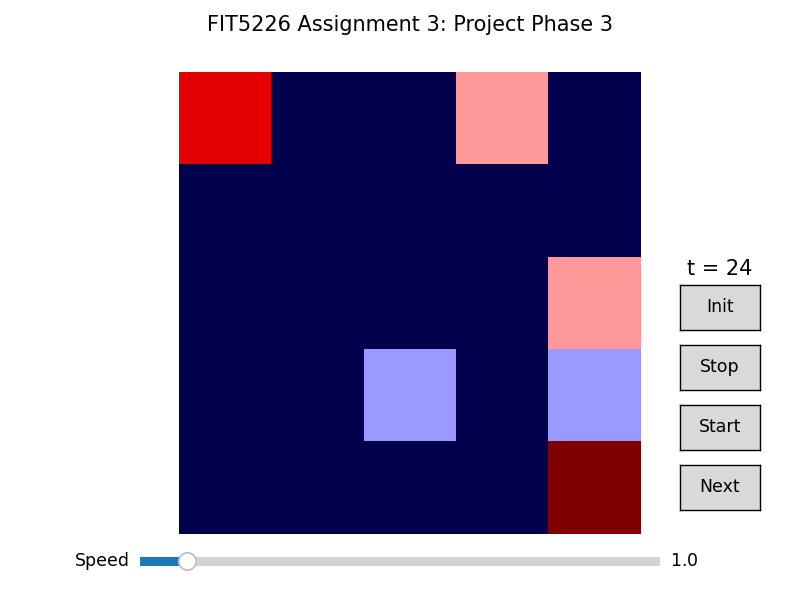

In [14]:
%matplotlib nbagg
simulation(my_grid)

# Tester
### Testing without simulation
Uncomment the following code to save the time on waiting the simulation to produce the outcome. It will automatically stop by the time when the epsilon is smaller than 0.05. 

5000 more steps will be taken afterwards for testing purpose.  

In [15]:
# count = int(math.log(0.05, my_grid.agents[0].epsilon_decay_factor))
# while my_grid.agents[0].epsilon >= 0.05:
#     if my_grid.agents[0].episode_count % 10 == 0:
#         print(f"Episode count: {my_grid.agents[0].episode_count}/{count} | Time: {my_grid.time} | Epsilon: {my_grid.agents[0].epsilon}", end='\r' )
#     my_grid.update_grid_world()
        
# for i in range(5000):
#     if my_grid.agents[0].episode_count % 10 == 0:
#         print('Episode count: ', my_grid.agents[0].episode_count,'/',count, '| Time :',my_grid.time, '| Epsilon :',my_grid.agents[0].epsilon, end='\r')
#     my_grid.update_grid_world()

# Metrics Visualisation
### Graph which shows the steps taken for each agent to complete their own goal per episode

The graph below shows how the agents converge their steps taken throughout the episode done. Ideally, the agent will converged into the policy/ strategy which guranteed the shortest path with the most rewards.  

In [16]:
plot_q_learning(my_grid)

### Heatmap which shows the total number of occurrence for agent to handover from each coordinates of grid world. 

The darker the colour, the more times the agents to do the handover action at the corresponding coordinate.
### Justification of heatmap

Ideally, agents should be converged into a point such that they will do the handover action in the diagonal coordinates of the grid world according to our rewards structure designed. However, all agent are **not allowed to stay** but need to move. This leads to a scenario where the agent will choose to move in either left and right or up or down from the optimal handover point while waiting for the other agent. This causes an outcome of agent accidentally do the handover action at one position beside of the optimal point as shown in the heatmap below:


# Important notes to run the heatmap 

The requirement to run the heatmap visualisation below is to call "%matplotlib inline" which conflicts with the %matplotlib nbagg" required for the simulation to run. This conflict will cause the simulation to not display / run correctly so it is recommended that you **uncomment and run the heatmap visualisation (code below) only after the simulation is not needed anymore to avoid causing any bug.**

**Please run the plot_heatmap code twice as it does not display properly on the first time running for some unknown reasons.**

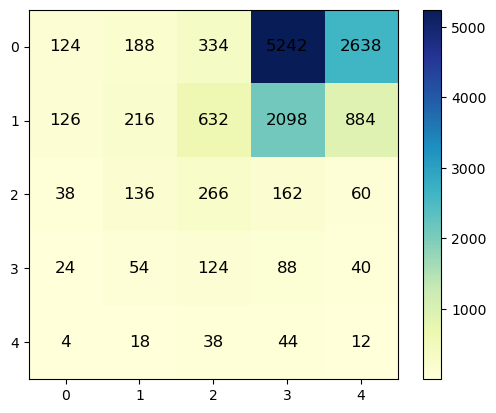

In [19]:
plot_heatmap(my_grid)